In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load the Data

In [2]:
df = pd.read_csv('data.csv')

## Drop one bad outlier
df = df[df['HIVincidence'] < df['HIVincidence'].max()]
df.head()

,AMAT_fac,HIVincidence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,Med_TMAT_fac,Population,SA_fac,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0.0,10.9,1.0,0.0,1.0,2.0,0.0,0.0,55035.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,8.7,4.0,0.0,3.0,1.0,0.0,0.0,203690.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,26270.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,22561.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,10.4,1.0,0.0,1.0,1.0,0.0,0.0,57676.0,1.0,...,0,0,0,0,0,0,0,0,0,0


## Separate into X and y


In [3]:
try:
    y = df.pop('HIVincidence')
except:
    pass
X = df.values

## How many observations have Zero incidence?

## ~75%

In [4]:
(y==0).mean()

0.7459128065395095

## Scale all Features

In [5]:
from sklearn.preprocessing import StandardScaler as SS
X = SS().fit_transform(X)

## Train/Test Split

In [6]:
from sklearn.model_selection import train_test_split as TTS
X_train, X_test, y_train, y_test = TTS(X,y, random_state = 2)

## Make a very simple model to predict `Zero` or `Non-Zero` HIV Incidence

In [7]:
from sklearn.linear_model import LogisticRegression as LR
model = LR(max_iter = 1000).fit(X_train,y_train>0)


## Score the Model. 

In [8]:
model.score(X_train, y_train>0), model.score(X_test, y_test>0) 

(0.9168937329700273, 0.9155313351498637)

## 90% Accuracy is a reasonable starting point for such a simple model.
 
## Now we'll look at only the portion of the data with non-zero HIV Incidence and make a regression model

In [9]:
HIV_X = X[y>0]
HIV_y = y[y>0]

In [10]:
HIV_X.shape

(746, 81)

In [11]:
(HIV_X_train, 
 HIV_X_test, 
 HIV_y_train, 
 HIV_y_test) = TTS(HIV_X,HIV_y, random_state=2)

# First, let's look a purely LASSO model.


## Fit 100 different LASSO Models with alpha in the range of $10^{-3}$ to $10$

In [12]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse

train_score, test_score = [],[]
train_r2, test_r2 = [], []
coefs = []

alphas = np.logspace(-3, 1, 100)

for alpha in alphas:
    regression = Lasso(alpha = alpha, max_iter = 10000)
    regression.fit(HIV_X_train, HIV_y_train)
    
    train_score.append(mse(HIV_y_train, regression.predict(HIV_X_train), squared = False))    
    test_score.append(mse(HIV_y_test, regression.predict(HIV_X_test), squared = False))
    
    train_r2.append(regression.score(HIV_X_train, HIV_y_train))
    test_r2.append(regression.score(HIV_X_test, HIV_y_test))

    coefs.append(regression.coef_)
    


## Plot the Train and Test RMSE Error.
## Identify the alpha value that yields the lowest Test RMSE

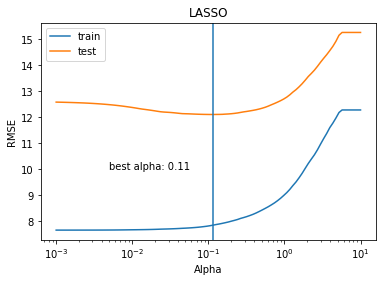

In [13]:
plt.plot(alphas, train_score, label = 'train')   
plt.plot(alphas, test_score, label = 'test')
plt.legend()
best_alpha = alphas[np.argmax(test_r2)]
plt.axvline(best_alpha)
plt.title("LASSO")
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.xscale('log')
plt.annotate(f'best alpha: {round(best_alpha,2)}',xy=(.005, 10));

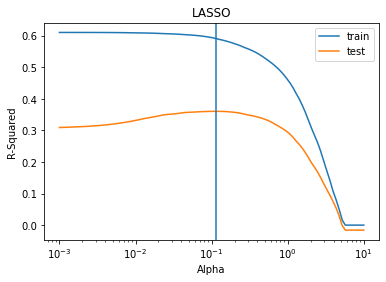

In [14]:
plt.plot(alphas, train_r2, label = 'train')   
plt.plot(alphas, test_r2, label = 'test')
plt.legend()

plt.axvline(best_alpha)
plt.title("LASSO")
plt.xlabel('Alpha')
plt.ylabel('R-Squared')
plt.xscale('log')

In [15]:
best_alpha

0.11497569953977368

## Plot the coefficients and a vertical line to indicate the best alpha value.

## Notice that at this alpha value, some of our coefficients are zero

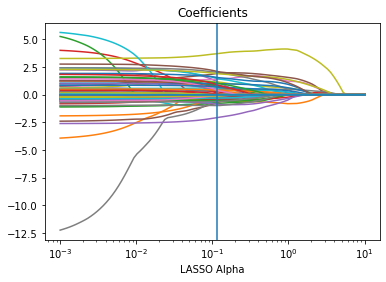

In [16]:
plt.plot(alphas, coefs)
plt.axvline(best_alpha)
plt.title('Coefficients')
plt.xscale('log')
plt.xlabel('LASSO Alpha');

## Build our final model based on the alpha value that gives lowest test RMSE

In [17]:
best_model = Lasso(alpha = best_alpha, max_iter = 10000)
best_model.fit(HIV_X_train, HIV_y_train)

Lasso(alpha=0.11497569953977368, max_iter=10000)

## Use this best model to make predictions and compare to actuals

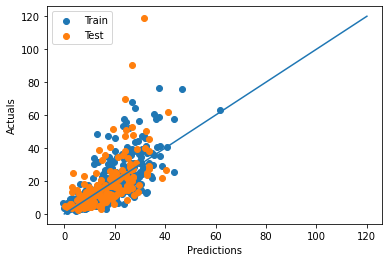

In [18]:
plt.scatter(best_model.predict(HIV_X_train), HIV_y_train, label = 'Train')
plt.scatter(best_model.predict(HIV_X_test), HIV_y_test, label = 'Test')
plt.legend()
plt.plot([0,120],[0,120])
plt.xlabel('Predictions')
plt.ylabel('Actuals');



### How many coefficients were deleted from the model?

In [19]:
(best_model.coef_==0).sum()

22

### Which columns were not deleted?

In [20]:
print('\n'.join(df.columns[best_model.coef_!=0]))

AMAT_fac
Med_AMAT_fac
Med_MH_fac
Med_SA_fac
Med_SMAT_fac
Population
SMAT_fac
TMAT_fac
drugdeathrate
drugdeathrate_est
mme_percap
pctunins
num_SSPs
bup_phys
drugdep
pctunmetneed
nonmedpain
MSM12MTH
%msm12month
%msm5yr
unemployment_rate
poverty_rate
AL
AR
AZ
CA
CO
CT
DC
DE
FL
GA
HI
IL
IN
LA
MA
MD
ME
MI
MO
MS
NC
NJ
NM
NV
NY
OH
OK
OR
RI
SC
TN
TX
UT
VA
VT
WA
WI


### Which coefficients were deleted?

In [21]:
print('\n'.join(df.columns[best_model.coef_==0]))

MH_fac
Med_TMAT_fac
SA_fac
drugdeaths
partD30dayrxrate
ADULTMEN
MSM5YEAR
household_income
AK
IA
ID
KS
KY
MN
MT
ND
NE
NH
PA
SD
WV
WY
